# A/B testing

Two-tailed unpaired test for proportions where a new landing page is tested, and subsequent user conversions are measured.

The hypotheses are:
- Null Hypothesis (H₀): There is no difference in conversion rates between Group A and Group B.
- Alternative Hypothesis (H₁): There is a difference in conversion rates between Group A and Group B.

In [1]:
import pandas as pd
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

import kagglehub
import os

# Import dataset

Kaggle dataset is used: https://www.kaggle.com/datasets/zhangluyuan/ab-testing

In [2]:
path = kagglehub.dataset_download("zhangluyuan/ab-testing")
df_kaggle = pd.read_csv(path + "\\" + os.listdir(path)[0])
df_kaggle.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


# EDA

In [3]:
def explore_dataset(
    in_df: pd.DataFrame
    , in_ids: tuple
    , in_types_dict: dict
    , out_size_text = "- dataset size"
    , out_dup_text = "- number of fully duplicated rows"
    , out_missed_text = "Columns are expected but not found in the dataset: "
) -> pd.DataFrame:
    """
    Quick dataset overview for EDA
    """
    print(f"{in_df.shape[0]} {out_size_text}")
    print(f"{in_df.duplicated().sum()} {out_dup_text}")
    
    for ids in in_ids:
        dup_ids = in_df[ids].duplicated().sum()
        if dup_ids > 0:
            print(f"{dup_ids} - number of duplicated {ids}")
        else:
            print(f"No duplicated {ids}")
    
    out_df = pd.DataFrame(in_df.dtypes, columns=["primary_type"])\
                            .reset_index()\
                            .rename(columns={"index": "column"})
    out_df["desired_type"] = out_df["column"].map(in_types_dict)
    out_df['count'] = in_df.count().values
    out_df['null_values'] = in_df.isnull().sum().values
    out_df['unique_values'] = in_df.nunique().values
    
    missing_columns = [col for col in in_types_dict.keys() if col not in in_df.columns]
    if missing_columns:
        print(f"{out_missed_text} {missing_columns}")
    
    return out_df

In [4]:
explore_dataset(
    df_kaggle
    , ("user_id",)
    , {
        "user_id": int
        , "timestamp": object
        , "group": object
        , "landing_page": object
        , "converted": int
    }
)

294478 - dataset size
0 - number of fully duplicated rows
3894 - number of duplicated user_id


,column,primary_type,desired_type,count,null_values,unique_values
0,user_id,int64,<class 'int'>,294478,0,290584
1,timestamp,object,<class 'object'>,294478,0,294478
2,group,object,<class 'object'>,294478,0,2
3,landing_page,object,<class 'object'>,294478,0,2
4,converted,int64,<class 'int'>,294478,0,2


As we can see, 3894 user_ids are duplicated. Let's take a look on some examples.

## Duplicated data

In [5]:
df_kaggle.groupby("user_id").count()["timestamp"].reset_index().sort_values(by = "timestamp", ascending = False)[:2]

,user_id,timestamp
91655,729669,2
179531,825266,2


In [6]:
df_kaggle[df_kaggle["user_id"] == 729669]

,user_id,timestamp,group,landing_page,converted
23245,729669,2017-01-19 19:36:06.004887,treatment,new_page,1
222921,729669,2017-01-14 12:54:09.480949,treatment,old_page,1


It seems to be quiet logical that users from control group see old page, while new page is related to treatment group.

In [7]:
df_kaggle.groupby(["group", "landing_page"]).count()

user_id  timestamp  converted
group     landing_page                               
control   new_page         1928       1928       1928
          old_page       145274     145274     145274
treatment new_page       145311     145311     145311
          old_page         1965       1965       1965

However, some amount of customers sees both, which should be incorrect.

In [8]:
df_dup = df_kaggle.groupby("user_id").count()["timestamp"].reset_index()
df_dup = df_dup[df_dup["timestamp"] == 2].rename(columns = {"timestamp": "cnt"})

df_new_page = df_kaggle[df_kaggle["landing_page"] == "new_page"].groupby("user_id").count()["timestamp"].reset_index()
df_new_page = df_new_page[df_new_page["timestamp"] == 2].rename(columns = {"timestamp": "cnt_new"})

df_old_page = df_kaggle[df_kaggle["landing_page"] == "old_page"].groupby("user_id").count()["timestamp"].reset_index()
df_old_page = df_old_page[df_old_page["timestamp"] == 2].rename(columns = {"timestamp": "cnt_old"})

df_dup_check = df_kaggle.merge(df_dup, on = "user_id", how = "left")
df_dup_check = df_dup_check.merge(df_new_page, on = "user_id", how = "left")
df_dup_check = df_dup_check.merge(df_old_page, on = "user_id", how = "left")

print(f"""
Users who see:
- old_page twice: {len(set(df_dup_check[df_dup_check["cnt_old"] == 2]["user_id"]))}
- new_page twice: {len(set(df_dup_check[df_dup_check["cnt_new"] == 2]["user_id"]))}
- both old and new: {len(set(df_dup_check[
                        (df_dup_check["cnt"] == 2) 
                        & (df_dup_check["cnt_new"].isnull()) 
                        & (df_dup_check["cnt_old"].isnull())
                    ]["user_id"]))}

Total: {
len(set(df_dup_check[df_dup_check["cnt_old"] == 2]["user_id"]))
+ len(set(df_dup_check[df_dup_check["cnt_new"] == 2]["user_id"]))
+ len(set(df_dup_check[
                        (df_dup_check["cnt"] == 2) 
                        & (df_dup_check["cnt_new"].isnull()) 
                        & (df_dup_check["cnt_old"].isnull())
                    ]["user_id"]))
}
""")


Users who see:
- old_page twice: 974
- new_page twice: 922
- both old and new: 1998

Total: 3894



## Timestamps

Now let's take a look on timestamp data: min, max and the distribution between them.

In [9]:
print(f'Min date: {min(df_kaggle["timestamp"])}, Max date: {max(df_kaggle["timestamp"])}')

Min date: 2017-01-02 13:42:05.378582, Max date: 2017-01-24 13:41:54.460509


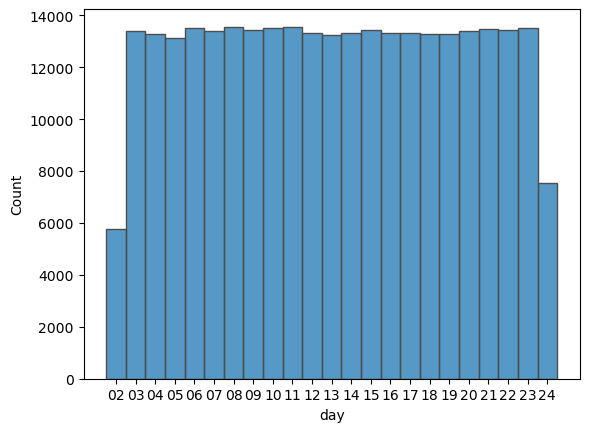

In [10]:
df_dt = df_kaggle.copy()
df_dt["day"] = df_dt["timestamp"].apply(lambda x: x[8:10])

system_hist = sns.histplot(
    df_dt.sort_values(by = "day")
    , x = "day"
    , palette = "light:m_r"
    , edgecolor = ".3"
    , linewidth = 1
)

## Conclusions

While seeing both old and new pages looks like a bug, we still can consider double views of the same page as a correct pattern - if the dataset if aggregated on event level, not on user one.

However, comparatevily small amount of these groups looks like a bug, so the analysis is prepared taking into account following assumptions: 
- Only first view of user is included into the dataset
- Column 'group' is dropped, while users who have firstly seen 'old_page' are considered as control group, and respectively first 'new_page' is a treatment group.
- Column 'timestamp' is dropped, the data is distributed evenly, the expirment was started at 2017-01-02 and stopped at 2017-01-24, only the first and the last days contain less data.

In [11]:
df_an = df_kaggle.copy()
df_min_date = df_kaggle.copy()
#cause it's string
df_min_date["timestamp"] = pd.to_datetime(df_min_date["timestamp"])
df_an["timestamp"] = pd.to_datetime(df_an["timestamp"])

df_min_date = df_min_date.groupby("user_id").min()["timestamp"].reset_index()
df_an = df_an.merge(df_min_date, on = ["user_id", "timestamp"], how = "inner")

explore_dataset(
    df_an
    , ("user_id",)
    , {
        "user_id": int
        , "timestamp": "datetime64[ns]"
        , "group": object
        , "landing_page": object
        , "converted": int
    }
)

290584 - dataset size
0 - number of fully duplicated rows
No duplicated user_id


,column,primary_type,desired_type,count,null_values,unique_values
0,user_id,int64,<class 'int'>,290584,0,290584
1,timestamp,datetime64[ns],datetime64[ns],290584,0,290584
2,group,object,<class 'object'>,290584,0,2
3,landing_page,object,<class 'object'>,290584,0,2
4,converted,int64,<class 'int'>,290584,0,2


In [12]:
df_fin = df_an[["landing_page", "converted"]].rename(columns = {"landing_page": "group"})
df_fin["group"] = df_fin["group"].apply(lambda x: "control" if x == "old_page" else "treatment")
df_fin.head()

,group,converted
0,control,0
1,control,0
2,treatment,0
3,treatment,0
4,control,1


For now we're ready for the analysis.

# Analysis

Here we perform two-tailed unpaired z-test for proportions.

In [18]:
class StatTestProportionTwoSamples():
    def __init__(
        self
        , data_a
        , data_b
        , tails = 1
        , alpha = 0.05
    ):
        """
        This class is for unpaired test of two groups with binomial distribution
        """
        try:
            #samples data
            self.array_a, self.array_b = np.array(data_a), np.array(data_b)
            if len(self.array_a) == 0 or len(self.array_b) == 0:
                raise ValueError("No data in array")

            #test parameters
            self.tails = tails
            if self.tails not in (1, 2):
                raise ValueError("tails must be 1 or 2")

            self.alpha = alpha
            self.z_critical = (norm.ppf(1 - alpha) 
                                if self.tails == 1
                                else norm.ppf(1 - alpha / 2))
            
        except:
            print("Incorrect data format")

    def sample_stats(self):
        #samples size
        self.size_a, self.size_b = len(self.array_a), len(self.array_b)
            
        #samples mean
        self.mean_a, self.mean_b = np.mean(self.array_a), np.mean(self.array_b)
        
        #variance
        self.var_a, self.var_b = (self.mean_a * (1 - self.mean_a)
                                , self.mean_b * (1 - self.mean_b))
        
        #st dev
        self.std_a, self.std_b = (np.sqrt(self.mean_a * (1 - self.mean_a))
                                , np.sqrt(self.mean_b * (1 - self.mean_b)))

        #st errors
        self.st_err_a, self.st_err_b = (np.sqrt(self.mean_a * (1 - self.mean_a) / self.size_a)
                                    , np.sqrt(self.mean_b * (1 - self.mean_b) / self.size_b))

        #common st err 
        self.st_err_pooled = np.sqrt(self.st_err_a**2 + self.st_err_b**2)
        
        #confidence intervals
        ci_level = 0.95
        z_value = norm.ppf(1 - (1 - ci_level) / 2)
        self.ci_left_a, self.ci_right_a = (self.mean_a - z_value * self.st_err_a
                                        , self.mean_a + z_value * self.st_err_a)
        self.ci_left_b, self.ci_right_b = (self.mean_b - z_value * self.st_err_b
                                        , self.mean_b + z_value * self.st_err_b)
        print(f"""
Sample A:
Size: {self.size_a}
Mean: {self.mean_a:.4f}, [{self.ci_left_a:.4f}, {self.ci_right_a:.4f}] CI 95%
Variance: {self.var_a:.6f}
Standard deviation: {self.std_a:.6f}
Standart error: {self.st_err_a:.6f}

Sample B:
Size: {self.size_b}
Mean: {self.mean_b:.4f}, [{self.ci_left_b:.4f}, {self.ci_right_b:.4f}] CI 95%
Variance: {self.var_b:.6f}
Standard deviation: {self.std_b:.6f}
Standart error: {self.st_err_b:.6f}
""")

    def check_variances(self):
        if self.var_a / self.var_b < 2 and self.var_b / self.var_a < 2:
            print(f"""
Variance check: Ok! 
{self.var_a:.4f} and {self.var_b:.4f} are close enough by Rule of Thumb
""")
        else:
            print(f"""
Variance check: Not ok! 
{self.var_a:.4f} and {self.var_b:.4f} are NOT close enough by Rule of Thumb
""")
    
    def check_normality(self):
        n_a = self.size_a
        n_b = self.size_b
        p_a = self.mean_a
        p_b = self.mean_b
        np_nq_values = [
            n_a * p_a
            , n_a * (1 - p_a)
            , n_b * p_b
            , n_b * (1 - p_b)
        ]
        if any(value < 5 for value in np_nq_values):
            print(f"""
Normality check: Not ok! 
The normal approximation is NOT appliable to the binomial distribution.
Some of np and nq are < 5: {np_nq_values}
We need to have a larger sample or more positive outcomes.\n""")
        else:
            print(f"""
Normality check: Ok! 
The normal approximation is appliable to the binomial distribution.
All np and nq are >= 5: {np_nq_values}\n""")
            
    def test_stats(self):
        """
        Calculating z-statistics and p-value
        """
        self.SE = (np.sqrt(
                    self.mean_a * (1 - self.mean_a) / self.size_a 
                    + self.mean_b * (1 - self.mean_b) / self.size_b))
        self.z_score = (self.mean_a - self.mean_b) / self.SE
        self.z_critical = (self.z_critical 
                            if self.z_score >=0
                            else -self.z_critical)
        self.p_value = (1 - norm.cdf(abs(self.z_score)) 
                            if self.tails == 1
                            else 2 * (1 - norm.cdf(abs(self.z_score))))
        
        if self.p_value < self.alpha:
            reject = "Reject H0"
        else:
            reject = "Fail to reject H0"
        
        print(f"""
SE: {self.SE:.5f}
z_score: {self.z_score:.5f}
z_critical: {self.z_critical:.5f}
p_value: {self.p_value:.10f}

Conclusion: {reject}
""")
        
    def samples_plot(self, color_a = 'blue', color_b = 'orange'):
        """
        Visualization of two probability density functions for normal distributions
        with confidence intervals
        """
        
        #x range for linspace
        threshold_a_upper = self.mean_a + self.z_critical * self.st_err_a
        threshold_a_lower = (self.mean_a - self.z_critical * self.st_err_a 
                                if self.tails == 2
                                else self.mean_a)
        threshold_b_upper = self.mean_b + self.z_critical * self.st_err_b
        threshold_b_lower = (self.mean_b - self.z_critical * self.st_err_b 
                                if self.tails == 2\
                                else self.mean_b)

        lin_start = min(self.ci_left_a, self.ci_left_b
                        , threshold_a_lower, threshold_b_lower) - 0.001
        lin_end = max(self.ci_right_a, self.ci_right_b
                      , threshold_a_upper, threshold_b_upper) + 0.001
        x = np.linspace(lin_start, lin_end, 1000)

        #normal distribution
        pdf_a = norm.pdf(x, self.mean_a, self.st_err_a)
        pdf_b = norm.pdf(x, self.mean_b, self.st_err_b)

        fig, ax = plt.subplots(figsize=(10, 6))

        ax.plot(x, pdf_a, label = 'Group A', color = color_a, linewidth = 2)
        ax.plot(x, pdf_b, label = 'Group B', color = color_b, linewidth = 2)

        #means
        ax.axvline(self.mean_a, color = color_a, linestyle='--', linewidth=2
                   , label=f'Mean A {self.mean_a:.4f}')
        ax.axvline(self.mean_b, color = color_b, linestyle='--', linewidth=2
                   , label=f'Mean B {self.mean_b:.4f}')

        #ci
        ax.axvline(self.ci_left_a, color = color_a, linestyle=':', linewidth=1)
        ax.axvline(self.ci_right_a, color = color_a, linestyle=':', linewidth=1
                   , label=f'CI A [{self.ci_left_a:.4f}, {self.ci_right_a:.4f}]')
        ax.axvline(self.ci_left_b, color = color_b, linestyle=':', linewidth=1)
        ax.axvline(self.ci_right_b, color = color_b, linestyle=':', linewidth=1
                   , label=f'CI B [{self.ci_left_b:.4f}, {self.ci_right_b:.4f}]')        
        
        ax.set_xlabel('Proportion')
        ax.set_ylabel('Density')
        ax.set_title('Normal Distributions of Proportions for Group A and B')
        ax.legend()

        plt.show()                

    
    def z_stat_plot(self):
        """
        Distribution of Z-statistics
        """
        x_z = np.linspace(-4, 4, 1000)
        pdf_z = norm.pdf(x_z, 0, 1)

        fig, ax = plt.subplots(figsize=(10, 6))

        ax.plot(x_z, pdf_z, label = "Standard Normal Distribution", color = 'black')

        #alpha region for significance
        if self.tails == 1:
            ax.fill_between(x_z, 0, pdf_z
                            , where=(x_z >= self.z_critical)
                            , color = 'red', alpha = 0.2
                            , label = "Alpha Region (Significance Level)")
        else:
            ax.fill_between(x_z, 0, pdf_z
                            , where=(x_z >= self.z_critical) | (x_z <= -self.z_critical)
                            , color = 'red', alpha = 0.2
                            , label = "Alpha Region (Significance Level)")

        #calculated z-score
        ax.axvline(self.z_score, color='purple', linestyle='-', linewidth=2
                   , label=f'Calculated Z-Score = {self.z_score:.2f}')

        #critical z-score
        ax.axvline(self.z_critical, color='blue', linestyle='--', linewidth=1.5
                   , label=f'Critical Z-Score = {self.z_critical:.2f}')
        if self.tails == 2:
            ax.axvline(-self.z_critical, color='blue', linestyle='--', linewidth=1.5)

        ax.set_xlabel('Z-Score')
        ax.set_ylabel('Density')
        ax.set_title('Z-Statistic Distribution for Two Proportions Comparison')
        ax.legend()

        plt.show()
            
    def output_data(self):
        """
        All related data as a dict
        """
        out = {
            "size_a": self.size_a
            , "mean_a": self.mean_a
            , "var_a": self.var_a
            , "std_a": self.std_a
            , "st_err_a": self.st_err_a
            , "ci_a": [self.ci_left_a, self.ci_right_a]
            , "size_b": self.size_b
            , "mean_b": self.mean_b
            , "var_b": self.var_b
            , "std_b": self.std_b
            , "st_err_b": self.st_err_b
            , "ci_b": [self.ci_left_b, self.ci_right_b]
            , "se": self.SE
            , "z_score": self.z_score
            , "z_critical": self.z_critical
            , "p_value": self.p_value
        }
        return out

## Samples statistics

Calculating sample_size, mean, variation and standart error for each group.

In [19]:
group_a = df_fin[df_fin["group"] == "control"]["converted"]
group_b = df_fin[df_fin["group"] == "treatment"]["converted"]

f = StatTestProportionTwoSamples(group_a, group_b, tails = 2)
f.sample_stats()


Sample A:
Size: 145293
Mean: 0.1205, [0.1188, 0.1222] CI 95%
Variation: 0.105991
Standard deviation: 0.000854
Standart error: 0.000854

Sample B:
Size: 145291
Mean: 0.1187, [0.1171, 0.1204] CI 95%
Variation: 0.104636
Standard deviation: 0.000849
Standart error: 0.000849



## Normality check

Check if normal approximation is available

In [20]:
f.check_normality()


Normality check: Ok! 
The normal approximation is appliable to the binomial distribution.
All np and nq are >= 5: [17510.0, 127783.0, 17251.0, 128040.0]



## Variances check

Confirm similarity of variances

In [21]:
f.check_variances()


Variance check: Ok! 
0.1060 and 0.1046 are close enough by Rule of Thumb



## Test statistics

In [22]:
f.test_stats()


SE: 0.00120
z_score: 1.47918
z_critical: 1.95996
p_value: 0.1390931645

Conclusion: Fail to reject H0



So, we fail to reject H0 according calculated p-value, let's visualize why.

## Samples distribution

Basically we'd like confidence intervals not overlap (areas between the thin dashed lines).

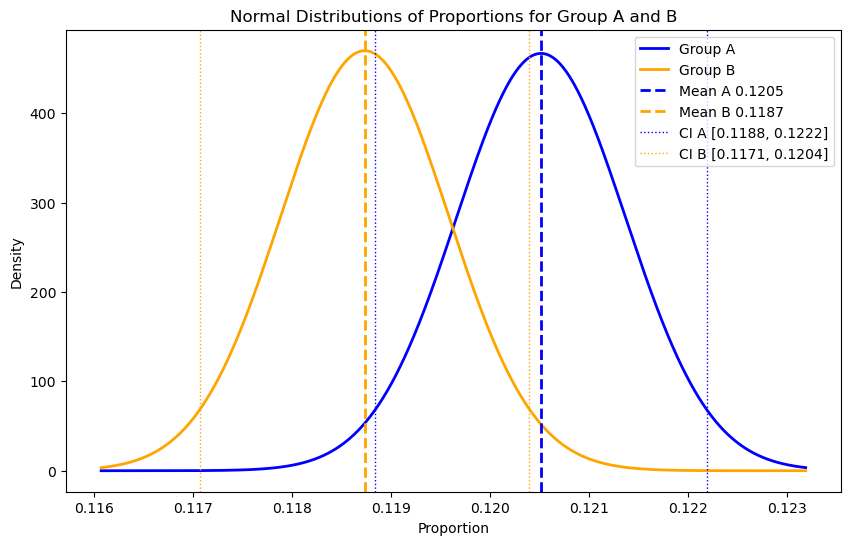

In [23]:
f.samples_plot()

## Z-statistics distribution

Basically we'd like to see calculated z-score out of critical z borders.

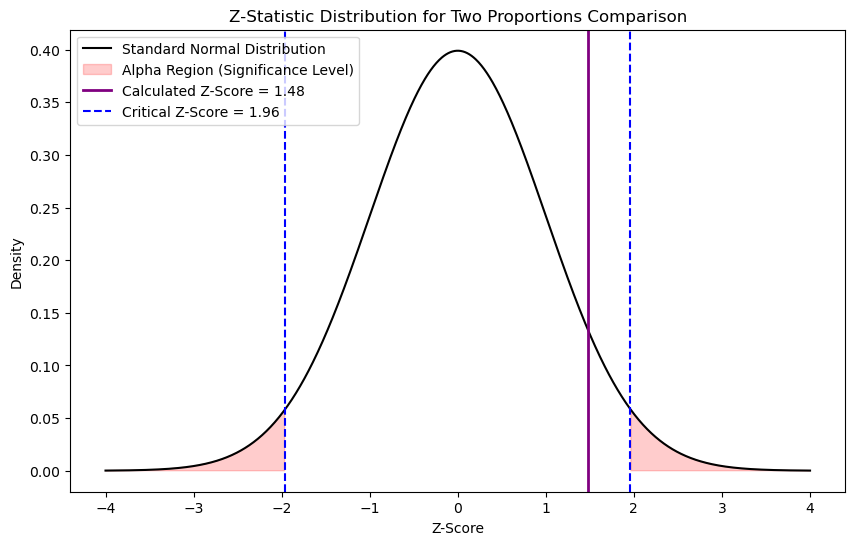

In [24]:
f.z_stat_plot()